In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys
#sys.path.insert(0, '/usr/users/vogg/FairMOT/src')
#sys.path.insert(0, '/usr/users/vogg/FairMOT/src/lib')
#sys.path.insert(0, '/opt/conda/envs/FairMOT/lib/python3.8/site-packages')
#sys.path.insert(0, '/usr/users/vogg/FairMOT/DCNv2')
#sys.path
import logging
import os
import re
import motmetrics as mm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from adjustText import adjust_text
import torch.nn.functional as F

import _init_paths
from opts import opts
from models.model import create_model, load_model
from models.decode import mot_decode, _nms, _topk
from tracking_utils.utils import *
from tracking_utils.log import logger
from tracking_utils.kalman_filter import KalmanFilter
from models import *
from utils.post_process import ctdet_post_process
from utils.image import get_affine_transform
from models.utils import _tranpose_and_gather_feat
import datasets.jde as datasets

ModuleNotFoundError: No module named 'motmetrics'

In [79]:
model = create_model('dla_34', heads =  {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}, 
                     head_conv = 256)

model = load_model(model, '../models/mcqcp/model_150.pth')
model = model.to(torch.device('cuda'))
model.eval()
print('ok')

loaded ../models/mcqcp/model_150.pth, epoch 150
ok


In [80]:
path = "/usr/users/agecker/datasets/derek_monkey_imgs/warthog"
dataloader = datasets.LoadImages(path)

In [81]:
image_format = ['.jpg', '.jpeg', '.png', '.tif']
files = sorted(glob.glob('%s/*.*' % path))
files = list(filter(lambda x: os.path.splitext(x)[1].lower() in image_format, files))

In [86]:
img0 = cv2.imread(files[1])  # BGR
img0.shape

(1920, 2560, 3)

In [87]:
img_box, _, _, _ = letterbox(img0, height=608, width=1088)

# Normalize RGB
img = img_box[:, :, ::-1].transpose(2, 0, 1)
img = np.ascontiguousarray(img, dtype=np.float32)
img /= 255.0

im_blob = torch.from_numpy(img).cuda().unsqueeze(0)

width = img0.shape[1]
height = img0.shape[0]
inp_height = im_blob.shape[2]
inp_width = im_blob.shape[3]
c = np.array([width / 2., height / 2.], dtype=np.float32)
s = max(float(inp_width) / float(inp_height) * height, width) * 1.0
meta = {'c': c, 's': s,
        'out_height': inp_height // 4,
        'out_width': inp_width // 4}

with torch.no_grad():
    output = model(im_blob)[-1]
    hm = output['hm'].sigmoid_()
    wh = output['wh']
    id_feature = output['id']
    id_feature = F.normalize(id_feature, dim=1)
    reg = output['reg']

In [88]:
img_box.shape
#img.shape

(608, 1088, 3)

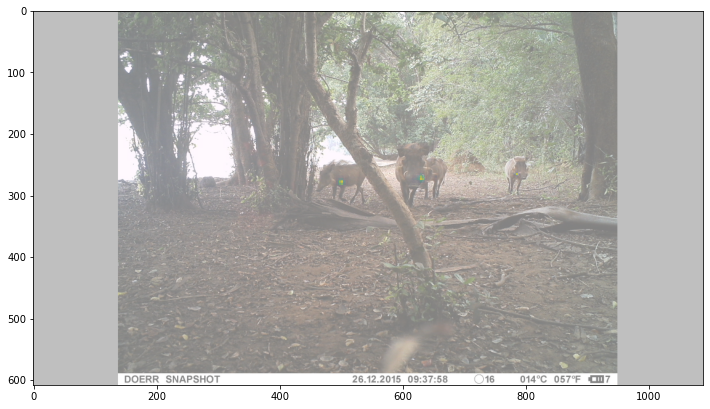

In [89]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB), alpha = 0.5)
hm_local = hm.cpu()
hm2 = _nms(hm_local)

scores, inds, clses, ys, xs = _topk(hm2, K = 50)
hm_local = F.interpolate(hm_local, scale_factor = 4)
hm_local = torch.squeeze(hm_local)


ax.imshow(hm_local, alpha = hm_local)
plt.show()

In [ ]:
## Videos